In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
def is_image_file(filepath):
    try:
        Image.open(filepath).verify()
        return True
    except (IOError, SyntaxError) as e:
        print(f"Warning: {filepath} is not a valid image file.")
        return False

In [3]:
# Load data function
def load_data(image_dir, csv_file, img_height=224, img_width=224):
    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Debug: Print column names to ensure correct loading
    print(f"Columns in CSV file: {df.columns.tolist()}")
    
    if 'Food item' not in df.columns or 'Calories' not in df.columns:
        raise KeyError("CSV file must contain 'Food item' and 'Calories' columns")
    
    df['Food item'] = df['Food item'].str.lower()  # Ensure consistency in food item names
    
    # Create a dictionary to map food items to calorie values
    food_to_calories = dict(zip(df['Food item'], df['Calories']))
    
    # Create lists to store images and labels
    images = []
    labels = []
    missing_food_items = set()
    
    # Iterate over the directories in the image directory
    for food_item in os.listdir(image_dir):
        food_item_path = os.path.join(image_dir, food_item)
        if os.path.isdir(food_item_path):
            food_item_lower = food_item.lower()
            if food_item_lower not in food_to_calories:
                missing_food_items.add(food_item_lower)
                continue  # Skip this food item
            
            for img_name in os.listdir(food_item_path):
                img_path = os.path.join(food_item_path, img_name)
                if is_image_file(img_path):  # Check if the file is a valid image
                    images.append(img_path)
                    labels.append(food_to_calories[food_item_lower])
    
    # Debug: Print missing food items
    if missing_food_items:
        print(f"Missing food items in CSV: {missing_food_items}")
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Split into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
    
    # Data generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='raw'
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_images, 'class': val_labels}),
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='raw'
    )
    
    return train_generator, val_generator

In [4]:

# Model definition
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

In [13]:
# Load data
image_dir = '../dataset/food_images'  # Replace with your path
csv_file = '../dataset/food_calories.csv'  # Replace with your path
img_height, img_width = 224, 224

train_generator, val_generator = load_data(image_dir, csv_file, img_height, img_width)

Columns in CSV file: ['Food item', 'Calories']
Found 2553 validated image filenames.
Found 639 validated image filenames.


In [14]:
# Create model
input_shape = (img_height, img_width, 3)
model = create_model(input_shape)

c:\Users\tridi\Desktop\Know Calorie\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Train the model
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/20


c:\Users\tridi\Desktop\Know Calorie\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - loss: 19699.1582 - mae: 111.8871 - val_loss: 4611.1167 - val_mae: 52.7230
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - loss: 4953.7451 - mae: 54.9089 - val_loss: 6390.8696 - val_mae: 65.5829
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - loss: 4642.3135 - mae: 52.3542 - val_loss: 4456.9150 - val_mae: 52.1545
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - loss: 4441.9873 - mae: 50.3433 - val_loss: 6571.6113 - val_mae: 67.8945
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - loss: 4813.4019 - mae: 53.9582 - val_loss: 4542.9048 - val_mae: 53.6647
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - loss: 4322.5215 - mae: 50.3645 - val_loss: 4213.6094 - val_mae: 50.8637
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 4202.3247 - mae: 49.2258 - val_loss: 4094.0664 - val_mae: 49.7259
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - loss: 4408.9878 - mae: 50.6505 - val_loss: 4236.5122 - val_mae: 48.4011
Epoch 9/2

In [16]:
# Save the model
model.save('calories_prediction_model.h5')

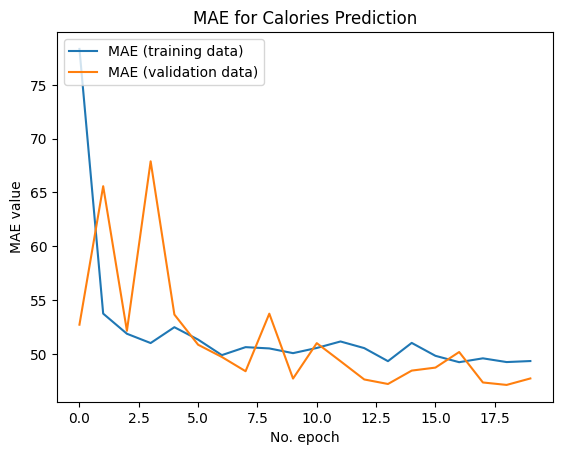

In [17]:
# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['val_mae'], label='MAE (validation data)')
plt.title('MAE for Calories Prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()